In [65]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import torch
import random
import tikzplotlib
# set random seed
random.seed(42)

In [2]:
raw_data = pd.read_pickle('./Data_Generation/df_pickle/final_02450_emb.pkl')

In [3]:
raw_data

,context,question,context_embedding,question_embedding
0,"Tue Herlau, Mikkel N Schmidt and Morten Mørup...",What is the purpose of the Introduction to Mac...,"[0.0128628155, -0.055795938, -0.02082023, 0.00...","[0.023956591, -0.05328789, -0.020539768, 0.049..."
1,"Tue Herlau, Mikkel N Schmidt and Morten Mørup...",What is the size of the data matrix X?,"[0.0128628155, -0.055795938, -0.02082023, 0.00...","[-0.029384881, -0.058231007, 4.166095e-05, 0.0..."
2,"Tue Herlau, Mikkel N Schmidt and Morten Mørup...",What is the difference between the dependent v...,"[0.0128628155, -0.055795938, -0.02082023, 0.00...","[0.054495554, 0.009531455, 0.037770104, -0.008..."
3,"Tue Herlau, Mikkel N Schmidt and Morten Mørup...",What is the range of values that the class ind...,"[0.0128628155, -0.055795938, -0.02082023, 0.00...","[-0.01423442, -0.04216911, 0.014260594, 0.0037..."
4,"Tue Herlau, Mikkel N Schmidt and Morten Mørup...",What is the purpose of the attributeNames cell...,"[0.0128628155, -0.055795938, -0.02082023, 0.00...","[0.06334706, -0.058257896, -0.006824675, 0.026..."
...,...,...,...,...
3350,"Rex Bryce, James A Hagans, Thomas C Chalmers,...",What is the title of the article published in ...,"[0.013220907, 0.011625264, 0.0013897644, -0.01...","[-0.0075637302, -0.05464517, 0.0072072605, 0.0..."
3351,"Rex Bryce, James A Hagans, Thomas C Chalmers,...","In which year was the article ""On the theory o...","[0.013220907, 0.011625264, 0.0013897644, -0.01...","[0.012623689, 0.0035005158, -0.006012459, -0.0..."
3352,"Rex Bryce, James A Hagans, Thomas C Chalmers,...","Who are the authors of the article ""Cluster en...","[0.013220907, 0.011625264, 0.0013897644, -0.01...","[0.026549067, -0.039300364, -0.008166317, -0.0..."
3353,"Rex Bryce, James A Hagans, Thomas C Chalmers,...",What is the name of the book published by Addi...,"[0.013220907, 0.011625264, 0.0013897644, -0.01...","[0.009545028, 0.035815652, 0.018275985, 0.0325..."


In [4]:
#Transform the embeddings to torch tensors
raw_data['question_embedding'] = raw_data['question_embedding'].apply(lambda x: torch.from_numpy(x))
raw_data['context_embedding'] = raw_data['context_embedding'].apply(lambda x: torch.from_numpy(x))

In [5]:
raw_data['context'].unique().shape

(671,)

In [6]:
raw_data['question'].unique().shape

(3344,)

In [7]:
raw_data.iloc[0]['question']

'What is the purpose of the Introduction to Machine Learning and Data Mining Lecture notes?'

In [8]:
# Save how each question is paired with an embedding and how each context is paired with an embedding so that the embeddings can be retrieved later
question_mapping = {}
context_mapping = {}

for _, row in raw_data.iterrows():
    question = row['question']  # Get the question text from the tuple
    embedding = row['question_embedding']  # Get the corresponding embedding
    if question not in question_mapping:  # If the question is not in the mapping add it
        question_mapping[question] = embedding

    context = row['context']  # Get the context text from the tuple
    embedding = row['context_embedding']  # Get the corresponding embedding
    if context not in context_mapping:  # If the context is not in the mapping add it
        context_mapping[context] = embedding








In [9]:
# Generate all possible combinations and check if they are in the original_pairs dictionary and add their embeddings which should not be the product of the embeddings of the question and answer
from collections import defaultdict
original_pairs = defaultdict(list)

for _, row in raw_data.iterrows():
    original_pairs[(row['question'], row['context'])].append(1)  # Append 1 to the list of labels

df = pd.DataFrame([(q, a, 1 if (q, a) in original_pairs else 0) for q, a in product(raw_data['question'].unique(), raw_data['context'].unique())], columns=['question', 'context', 'label'])


In [10]:
df['label'].value_counts()

0    2240469
1       3355
Name: label, dtype: int64

In [11]:
# Add the embeddings to the dataframe for the questions and contexts
df['question_embedding'] = df['question'].apply(lambda x: question_mapping[x])
df['context_embedding'] = df['context'].apply(lambda x: context_mapping[x])




In [12]:
df

,question,context,label,question_embedding,context_embedding
0,What is the purpose of the Introduction to Mac...,"Tue Herlau, Mikkel N Schmidt and Morten Mørup...",1,"[tensor(0.0240), tensor(-0.0533), tensor(-0.02...","[tensor(0.0129), tensor(-0.0558), tensor(-0.02..."
1,What is the purpose of the Introduction to Mac...,Cross-validation All variables mentioned abov...,0,"[tensor(0.0240), tensor(-0.0533), tensor(-0.02...","[tensor(-0.0076), tensor(-0.1338), tensor(-0.0..."
2,What is the purpose of the Introduction to Mac...,"In the preceding example, x2 = 4 and A2,3 = −...",0,"[tensor(0.0240), tensor(-0.0533), tensor(-0.02...","[tensor(-0.0055), tensor(-0.0753), tensor(0.00..."
3,What is the purpose of the Introduction to Mac...,"Finally, the reader should be familiar with t...",0,"[tensor(0.0240), tensor(-0.0533), tensor(-0.02...","[tensor(-0.0633), tensor(-0.0193), tensor(-0.0..."
4,What is the purpose of the Introduction to Mac...,as a shorthand for which theorems or rules ar...,0,"[tensor(0.0240), tensor(-0.0533), tensor(-0.02...","[tensor(0.0208), tensor(-0.0452), tensor(0.006..."
...,...,...,...,...,...
2243819,"Who wrote the article ""On the early history of...","In Probability, Dynamics and Causality, pages...",0,"[tensor(0.0127), tensor(0.0011), tensor(0.0156...","[tensor(0.0381), tensor(-0.0082), tensor(-0.00..."
2243820,"Who wrote the article ""On the early history of...","Springer New York, 2014 ISBN 9781461471370 UR...",0,"[tensor(0.0127), tensor(0.0011), tensor(0.0156...","[tensor(0.0220), tensor(0.0141), tensor(-0.000..."
2243821,"Who wrote the article ""On the early history of...",Nouvelles m´ethodes pour la d´etermination de...,0,"[tensor(0.0127), tensor(0.0011), tensor(0.0156...","[tensor(0.0142), tensor(0.0124), tensor(0.0043..."
2243822,"Who wrote the article ""On the early history of...","Judea Pearl, Madelyn Glymour, and Nicholas P ...",0,"[tensor(0.0127), tensor(0.0011), tensor(0.0156...","[tensor(-0.0058), tensor(0.0393), tensor(-0.02..."


In [13]:
# Add them together to a tuple
df['question'] = df.apply(lambda x: (x['question'],x['question_embedding']), axis = 1)
df['context'] = df.apply(lambda x: (x['context'],x['context_embedding']), axis = 1)

# Drop the embeddings
df = df.drop(['question_embedding', 'context_embedding'], axis = 1)

In [14]:
df['label'].value_counts()[:4]

0    2240469
1       3355
Name: label, dtype: int64

In [15]:
df[df['label'] == 1]


,question,context,label
0,(What is the purpose of the Introduction to Ma...,"( Tue Herlau, Mikkel N Schmidt and Morten Møru...",1
671,"(What is the size of the data matrix X?, [tens...","( Tue Herlau, Mikkel N Schmidt and Morten Møru...",1
1342,(What is the difference between the dependent ...,"( Tue Herlau, Mikkel N Schmidt and Morten Møru...",1
2013,(What is the range of values that the class in...,"( Tue Herlau, Mikkel N Schmidt and Morten Møru...",1
2684,(What is the purpose of the attributeNames cel...,"( Tue Herlau, Mikkel N Schmidt and Morten Møru...",1
...,...,...,...
2241139,(What is the title of the article published in...,"( Rex Bryce, James A Hagans, Thomas C Chalmers...",1
2241810,"(In which year was the article ""On the theory ...","( Rex Bryce, James A Hagans, Thomas C Chalmers...",1
2242481,"(Who are the authors of the article ""Cluster e...","( Rex Bryce, James A Hagans, Thomas C Chalmers...",1
2243152,(What is the name of the book published by Add...,"( Rex Bryce, James A Hagans, Thomas C Chalmers...",1


In [16]:
test_q = np.random.choice(df['question'].unique(), size = int(len(df['question'].unique())*0.20), replace = False)
# also for the context
test_c = np.random.choice(df['context'].unique(), size = int(len(df['context'].unique())*0.20), replace = False)

In [17]:
test = df[df['question'].isin(test_q)]
train = df[~df['question'].isin(test_q)]
test_ctx = df[df['question'].isin(test_q)].loc[df['context'].isin(test_c)]
train_ctx = df[~df['question'].isin(test_q)].loc[~df['context'].isin(test_c)]
# Resample the training data to have equal number of positive and negative samples
train_resample = pd.concat([train[train['label'] == 1].sample(len(train[train['label'] == 0]), replace = True), train[train['label'] == 0]])

In [18]:
train = train.sample(frac=1).reset_index(drop=True)
train_ctx = train_ctx.sample(frac=1).reset_index(drop=True)
train_resample = train_resample.sample(frac=1).reset_index(drop=True)

In [19]:
train_resample['label'].value_counts()

1    1792912
0    1792912
Name: label, dtype: int64

In [20]:
train['label'].value_counts()

0    1792912
1       2684
Name: label, dtype: int64

In [21]:
test['label'].value_counts()

0    447557
1       671
Name: label, dtype: int64

In [22]:
train['question'].value_counts()

(Which nodes remain in the network when illustrated with red in section 13.4?, [tensor(0.0244), tensor(-0.0930), tensor(-0.0272), tensor(0.0173), tensor(-0.0242), tensor(-0.0337), tensor(-0.0118), tensor(-0.0293), tensor(-0.0137), tensor(-0.0059), tensor(-0.0050), tensor(0.1116), tensor(0.0577), tensor(-0.0771), tensor(0.0067), tensor(-0.0232), tensor(0.0033), tensor(-0.0094), tensor(-0.0542), tensor(-0.0222), tensor(-0.0185), tensor(0.0605), tensor(-0.0116), tensor(-0.0222), tensor(-0.0205), tensor(0.0393), tensor(0.0067), tensor(-0.0020), tensor(0.0137), tensor(-0.0045), tensor(-0.0408), tensor(0.0336), tensor(-0.0215), tensor(-0.0276), tensor(-0.0091), tensor(0.0108), tensor(-0.0153), tensor(0.0147), tensor(-0.0599), tensor(-0.0328), tensor(-0.0759), tensor(0.0286), tensor(0.0174), tensor(-0.0249), tensor(0.0444), tensor(0.0253), tensor(0.0371), tensor(0.0324), tensor(-0.0549), tensor(0.0031), tensor(0.0220), tensor(0.0743), tensor(-0.0938), tensor(0.0111), tensor(-0.0161), tensor(0

In [23]:
test['question'].value_counts()

(What does the superscript T denote in this book?, [tensor(0.0475), tensor(-0.1530), tensor(-0.0102), tensor(0.0176), tensor(0.0010), tensor(0.0622), tensor(0.0045), tensor(0.0102), tensor(-0.0135), tensor(0.0111), tensor(0.0326), tensor(0.0185), tensor(0.0428), tensor(0.0220), tensor(0.0250), tensor(-0.0152), tensor(0.0007), tensor(-0.0018), tensor(0.0056), tensor(0.0148), tensor(-0.0081), tensor(0.0391), tensor(-0.0096), tensor(0.0387), tensor(-0.0380), tensor(-0.0011), tensor(0.0674), tensor(0.0131), tensor(0.0117), tensor(0.0413), tensor(0.0100), tensor(-0.0218), tensor(0.0593), tensor(0.0856), tensor(0.0040), tensor(-0.0039), tensor(-0.0467), tensor(-0.0351), tensor(-0.0014), tensor(0.0134), tensor(-0.0036), tensor(-0.0181), tensor(0.0100), tensor(-0.0185), tensor(0.0067), tensor(-0.0173), tensor(0.0168), tensor(-0.0027), tensor(-0.0872), tensor(0.0017), tensor(0.0197), tensor(0.0140), tensor(-0.0141), tensor(0.0386), tensor(0.0278), tensor(-0.0469), tensor(-0.0196), tensor(0.0199

In [24]:
len(train['context'].value_counts())

671

In [74]:
len(test['context'].value_counts())

671

In [75]:
train.to_pickle('./Data_Generation/df_pickle/train.pkl')
train_resample.to_pickle('./Data_Generation/df_pickle/train_resample.pkl')
test.to_pickle('./Data_Generation/df_pickle/test.pkl')

In [76]:
#Load the data
train = pd.read_pickle('./Data_Generation/df_pickle/train.pkl')
train_resample = pd.read_pickle('./Data_Generation/df_pickle/train_resample.pkl')
test = pd.read_pickle('./Data_Generation/df_pickle/test.pkl')


In [77]:
train

,question,context,label
0,(What are the input values used to evaluate th...,( 18.2 K-means clustering The goal of K-means ...,0
1,(Are the Mahanalobis distances between the two...,( The data: Next we should determine what data...,0
2,(What is the difference between the Mahalanobi...,( This technique is most often used in conjunc...,0
3,(How are the numerical values assigned to comp...,"( For instance, if a research group at another...",0
4,"(How can the value of w that maximizes p(w|X, ...",( Pairwise Euclidean distance between the 10 f...,0
...,...,...,...
1795591,"(In which journal was the article ""The Analysi...",( A further issue which should be mentioned is...,0
1795592,(How does the Simple Matching coefficient comp...,( Hunt’s algorithm is then applied recursively...,0
1795593,(What is supervised learning and how is it dif...,"( The lower-row of fig 12.2 shows NX(x, K = 5)...",0
1795594,(What is the technical formulation for ensurin...,( Histograms based on N = 16 bins of the four ...,0


Neural Net

In [25]:
from keras.models import Sequential
from keras.layers import Dense
import keras.metrics as metrics

In [26]:
# Make a neural network that should work with a data generator


neural_net = Sequential()
neural_net.add(Dense(256, input_dim=768*2, activation='relu'))
neural_net.add(Dense(256, activation='relu'))
neural_net.add(Dense(1, activation='sigmoid'))



neural_net.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'),
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR')])

neural_net_ctx = Sequential()
neural_net_ctx.add(Dense(256, input_dim=768*2, activation='relu'))
neural_net_ctx.add(Dense(256, activation='relu'))
neural_net_ctx.add(Dense(1, activation='sigmoid'))

neural_net_ctx.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'),
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR')])

neural_net_resample = Sequential()
neural_net_resample.add(Dense(256, input_dim=768*2, activation='relu'))
neural_net_resample.add(Dense(256, activation='relu'))
neural_net_resample.add(Dense(1, activation='sigmoid'))

neural_net_resample.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'),
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR')])




In [27]:
#Select the second element of the tuple which is the embedding:
X_train_q =  np.array(train['question'].apply(lambda x: x[1].numpy()))
X_train_c = np.array(train['context'].apply(lambda x: x[1].numpy()))

In [28]:
X_train_q[0]

array([ 2.44045872e-02, -9.29825231e-02, -2.71532349e-02,  1.73099302e-02,
       -2.41968129e-02, -3.36986706e-02, -1.18372375e-02, -2.92594619e-02,
       -1.36619452e-02, -5.92152029e-03, -5.03984420e-03,  1.11627705e-01,
        5.76934852e-02, -7.71037564e-02,  6.73925132e-03, -2.31665373e-02,
        3.26218549e-03, -9.44718812e-03, -5.41703738e-02, -2.22224481e-02,
       -1.85017884e-02,  6.04877695e-02, -1.15538975e-02, -2.22259220e-02,
       -2.04681698e-02,  3.93305272e-02,  6.67776912e-03, -2.01037480e-03,
        1.36833508e-02, -4.47503151e-03, -4.07520011e-02,  3.35744321e-02,
       -2.15091109e-02, -2.75509413e-02, -9.08921752e-03,  1.07973674e-02,
       -1.52688352e-02,  1.46837262e-02, -5.99098727e-02, -3.27617675e-02,
       -7.58673102e-02,  2.86195967e-02,  1.74332894e-02, -2.48925965e-02,
        4.43973430e-02,  2.52888743e-02,  3.70521694e-02,  3.23654823e-02,
       -5.48832342e-02,  3.13991425e-03,  2.20153816e-02,  7.43401945e-02,
       -9.38036889e-02,  

In [29]:
X_train_ctx_q = np.array(train_ctx['question'].apply(lambda x: x[1].numpy()))
X_train_ctx_c = np.array(train_ctx['context'].apply(lambda x: x[1].numpy()))

In [30]:
X_train_resample_q = np.array(train_resample['question'].apply(lambda x: x[1].numpy()))
X_train_resample_c = np.array(train_resample['context'].apply(lambda x: x[1].numpy()))

In [31]:
X_train_ctx_q[0].shape

(768,)

In [32]:
# Unpack the data to be a matrix of length N x D where D is the embedding dimension of 768, the array has 20 million rows so it is too big to fit in memory, instead we will use a generator to feed the data to the neural net


In [86]:
X_train_q[0].shape

(768,)

In [33]:
X_test_q = np.array(test['question'].apply(lambda x: x[1].numpy()))
X_test_c = np.array(test['context'].apply(lambda x: x[1].numpy()))

In [34]:
# Unpack the test data and concatenate the question and context embeddings. This is done by using a for loop to iterate through the rows of the dataframe and then using np.concatenate to join the two arrays
X_test_q_ = np.array([X_test_q[i] for i in range(len(X_test_q))])
X_test_c_ = np.array([X_test_c[i] for i in range(len(X_test_c))])

X_test = np.concatenate((X_test_q_, X_test_c_), axis=1)

In [35]:
X_test_ctx_q = np.array(test_ctx['question'].apply(lambda x: x[1].numpy()))
X_test_ctx_c = np.array(test_ctx['context'].apply(lambda x: x[1].numpy()))

In [36]:
X_test_ctx_q_ = np.array([X_test_ctx_q[i] for i in range(len(X_test_ctx_q))])
X_test_ctx_c_ = np.array([X_test_ctx_c[i] for i in range(len(X_test_ctx_c))])

X_test_ctx = np.concatenate((X_test_ctx_q_, X_test_ctx_c_), axis=1)

In [37]:
y_train = train['label'].values
y_test = test['label'].values



y_train_resample = train_resample['label'].values


In [38]:
y_train_ctx = train_ctx['label'].values
y_test_ctx = test_ctx['label'].values

In [91]:
# Load the numpy arrays


In [92]:
import zipfile
import io
import h5py

def saveCompressed(fh, **namedict):
    with zipfile.ZipFile(fh, mode="w", compression=zipfile.ZIP_DEFLATED, allowZip64=True) as zf:
        for k, v in namedict.items():
            np.save(f"{k}.npy", np.asanyarray(v))
            zf.write(f"{k}.npy")


In [108]:
# unpack the data
X_train_c[0].shape

(768,)

In [109]:
# Create a function that flattens the array and then reshapes it to be (N, 768)
import os

def flatten_and_save(array, chunk_size, save_dir, X = True):
    os.makedirs(save_dir, exist_ok=True)

    num_chunks = int(np.ceil(len(array) / chunk_size))

    index = np.empty((len(array), 2), dtype=np.int)
    filenames = []

    for i in range(num_chunks):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, len(array))

        # Flatten by concatenating the rows by axis 0 and then reshape to be (N, 768)
        if X:
            reshaped_chunk = np.concatenate(array[start:end], axis=0).reshape(-1, 768)
        else:
            reshaped_chunk = array[start:end]


        filename = f"chunk_{i}.npy"
        np.save(f"{save_dir}/{filename}", reshaped_chunk)
        filenames.append(filename)

        index[start:end, 0] = i
        index[start:end, 1] = reshaped_chunk.shape[0]

    np.save(f"{save_dir}/index.npy", index)
    np.save(f"{save_dir}/filenames.npy", np.array(filenames))


In [110]:
# Use the function to flatten and reshape the arrays
flatten_and_save(X_train_q, 100000, './Data_Generation/df_pickle/TEST_TRAIN_DATA/train_q')
flatten_and_save(X_train_c, 100000, './Data_Generation/df_pickle/TEST_TRAIN_DATA/train_c')
flatten_and_save(X_test_q, 100000, './Data_Generation/df_pickle/TEST_TRAIN_DATA/test_q')
flatten_and_save(X_test_c, 100000, './Data_Generation/df_pickle/TEST_TRAIN_DATA/test_c')

flatten_and_save(X_train_ctx_q, 100000, './Data_Generation/df_pickle/TEST_TRAIN_DATA/train_ctx_q')
flatten_and_save(X_train_ctx_c, 100000, './Data_Generation/df_pickle/TEST_TRAIN_DATA/train_ctx_c')
flatten_and_save(X_test_ctx_q, 100000, './Data_Generation/df_pickle/TEST_TRAIN_DATA/test_ctx_q')
flatten_and_save(X_test_ctx_c, 100000, './Data_Generation/df_pickle/TEST_TRAIN_DATA/test_ctx_c')

flatten_and_save(X_train_resample_q, 100000, './Data_Generation/df_pickle/TEST_TRAIN_DATA/train_resample_q')
flatten_and_save(X_train_resample_c, 100000, './Data_Generation/df_pickle/TEST_TRAIN_DATA/train_resample_c')


C:\Users\anton\AppData\Local\Temp\ipykernel_20272\1943177616.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index = np.empty((len(array), 2), dtype=np.int)


In [111]:
# Do the same for the labels
flatten_and_save(y_train, 100000, './Data_Generation/df_pickle/TEST_TRAIN_DATA/train_y', X = False)
flatten_and_save(y_test, 100000, './Data_Generation/df_pickle/TEST_TRAIN_DATA/test_y', X = False)

flatten_and_save(y_train_ctx, 100000, './Data_Generation/df_pickle/TEST_TRAIN_DATA/train_ctx_y', X = False)
flatten_and_save(y_test_ctx, 100000, './Data_Generation/df_pickle/TEST_TRAIN_DATA/test_ctx_y', X = False)

flatten_and_save(y_train_resample, 100000, './Data_Generation/df_pickle/TEST_TRAIN_DATA/train_resample_y', X = False)






C:\Users\anton\AppData\Local\Temp\ipykernel_20272\1943177616.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index = np.empty((len(array), 2), dtype=np.int)


In [39]:
# Create a generator that can use the saved numpy arrays to feed the data to the neural net
def generator(chunk_dir_q, chunk_dir_c, chunk_dir_y, batch_size):
    filenames = np.load(f"{chunk_dir_q}/filenames.npy")
    index = np.load(f"{chunk_dir_q}/index.npy")

    while True:
        np.random.shuffle(index)

        for i in range(len(filenames)):
            filename = filenames[index[i, 0]]
            start = np.sum(index[:i, 1])
            end = start + index[i, 1]

            X_q = np.load(f"{chunk_dir_q}/{filename}")
            X_c = np.load(f"{chunk_dir_c}/{filename}")
            y = np.load(f"{chunk_dir_y}/{filename}")

            assert len(X_q) == len(X_c) == len(y), "Mismatch in the lengths of arrays."

            indices = np.arange(len(y))
            np.random.shuffle(indices)

            for j in range(0, len(y), batch_size):
                batch_indices = indices[j:j + batch_size]

                batch_X_q = X_q[batch_indices]
                batch_X_c = X_c[batch_indices]
                batch_X = np.concatenate([batch_X_q, batch_X_c], axis=1)  # Combine question and context embeddings

                yield batch_X, y[batch_indices]

# Make a test for the generator:
gen = generator(chunk_dir_q='./Data_Generation/df_pickle/TEST_TRAIN_DATA/train_resample_q', chunk_dir_c='./Data_Generation/df_pickle/TEST_TRAIN_DATA/train_resample_c', chunk_dir_y='./Data_Generation/df_pickle/TEST_TRAIN_DATA/train_resample_y', batch_size=128)
X, y = next(gen)
print(X.shape, y.shape)
np.sum(y)


(128, 1536) (128,)


48

Neural network training

In [40]:
# Early stopping callback
import keras
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True)

In [59]:
# Fit the model with the generator and use early stopping to prevent overfitting
baseline_history = neural_net.fit(generator(chunk_dir_q='./Data_Generation/df_pickle/TEST_TRAIN_DATA/train_q', chunk_dir_c='./Data_Generation/df_pickle/TEST_TRAIN_DATA/train_c', chunk_dir_y= './Data_Generation/df_pickle/TEST_TRAIN_DATA/train_y', batch_size=128),
                    steps_per_epoch=len(y_train) // 12800, epochs=100,
                                  # validation data should also be a generator
                    validation_data=generator(chunk_dir_q='./Data_Generation/df_pickle/TEST_TRAIN_DATA/test_q', chunk_dir_c='./Data_Generation/df_pickle/TEST_TRAIN_DATA/test_c', chunk_dir_y= './Data_Generation/df_pickle/TEST_TRAIN_DATA/test_y', batch_size=128),
                    validation_steps=len(y_test) // 12800,
                                            verbose=1,
                                            callbacks=[early_stopping])

Epoch 1/100
140/140 [==============================] - 2s 16ms/step - loss: 0.0126 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 17894.0000 - fn: 26.0000 - accuracy: 0.9985 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5224 - prc: 0.0016 - val_loss: 0.0070 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 4477.0000 - val_fn: 3.0000 - val_accuracy: 0.9993 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4582 - val_prc: 5.6538e-04
Epoch 2/100
140/140 [==============================] - 1s 9ms/step - loss: 0.0118 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 17895.0000 - fn: 25.0000 - accuracy: 0.9986 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5360 - prc: 0.0027 - val_loss: 0.0129 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 4473.0000 - val_fn: 7.0000 - val_accuracy: 0.9984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4880 - val_prc: 0.0015
Epoch 3/100
140/140 [==============================] - 1s 9ms/step - loss: 0.0105 - tp: 0.0000e+0

In [60]:
baseline_history_ctx = neural_net_ctx.fit( generator(chunk_dir_q='./Data_Generation/df_pickle/TEST_TRAIN_DATA/train_ctx_q', chunk_dir_c='./Data_Generation/df_pickle/TEST_TRAIN_DATA/train_ctx_c', chunk_dir_y= './Data_Generation/df_pickle/TEST_TRAIN_DATA/train_ctx_y', batch_size=128),
                    steps_per_epoch=len(y_train_ctx) // 12800, epochs=100,
                                  # validation data should also be a generator
                    validation_data=generator(chunk_dir_q='./Data_Generation/df_pickle/TEST_TRAIN_DATA/test_ctx_q', chunk_dir_c='./Data_Generation/df_pickle/TEST_TRAIN_DATA/test_ctx_c', chunk_dir_y= './Data_Generation/df_pickle/TEST_TRAIN_DATA/test_ctx_y', batch_size=128),
                    validation_steps=len(y_test_ctx) // 12800,
                                            verbose=1,
                                            callbacks=[early_stopping])

Epoch 1/100
112/112 [==============================] - 2s 14ms/step - loss: 0.0133 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 14312.0000 - fn: 24.0000 - accuracy: 0.9983 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5192 - prc: 0.0019 - val_loss: 0.0108 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 767.0000 - val_fn: 1.0000 - val_accuracy: 0.9987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4074 - val_prc: 9.8579e-04
Epoch 2/100
112/112 [==============================] - 1s 9ms/step - loss: 0.0100 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 14318.0000 - fn: 18.0000 - accuracy: 0.9987 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5270 - prc: 0.0015 - val_loss: 0.0091 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 767.0000 - val_fn: 1.0000 - val_accuracy: 0.9987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4791 - val_prc: 0.0012
Epoch 3/100
112/112 [==============================] - 1s 9ms/step - loss: 0.0113 - tp: 0.0000e+00 

In [43]:
baseline_history_resample = neural_net_resample.fit(generator(chunk_dir_q='./Data_Generation/df_pickle/TEST_TRAIN_DATA/train_resample_q', chunk_dir_c='./Data_Generation/df_pickle/TEST_TRAIN_DATA/train_resample_c', chunk_dir_y= './Data_Generation/df_pickle/TEST_TRAIN_DATA/train_resample_y', batch_size=128),
                    steps_per_epoch=len(y_train_resample) // 12800, epochs=100,
                                  # validation data should also be a generator
                    validation_data=generator(chunk_dir_q='./Data_Generation/df_pickle/TEST_TRAIN_DATA/test_q', chunk_dir_c='./Data_Generation/df_pickle/TEST_TRAIN_DATA/test_c', chunk_dir_y= './Data_Generation/df_pickle/TEST_TRAIN_DATA/test_y', batch_size=128),
                    validation_steps=len(y_test) // 12800,
                                            verbose=1,
                                            callbacks=[early_stopping])

Epoch 1/100
280/280 [==============================] - 5s 14ms/step - loss: 0.3539 - tp: 14998.0000 - fp: 3115.0000 - tn: 14895.0000 - fn: 2832.0000 - accuracy: 0.8341 - precision: 0.8280 - recall: 0.8412 - auc: 0.9241 - prc: 0.9172 - val_loss: 0.1606 - val_tp: 6.0000 - val_fp: 280.0000 - val_tn: 4191.0000 - val_fn: 3.0000 - val_accuracy: 0.9368 - val_precision: 0.0210 - val_recall: 0.6667 - val_auc: 0.9465 - val_prc: 0.0379
Epoch 2/100
280/280 [==============================] - 3s 9ms/step - loss: 0.1143 - tp: 17608.0000 - fp: 1004.0000 - tn: 16835.0000 - fn: 393.0000 - accuracy: 0.9610 - precision: 0.9461 - recall: 0.9782 - auc: 0.9895 - prc: 0.9849 - val_loss: 0.0843 - val_tp: 2.0000 - val_fp: 127.0000 - val_tn: 4348.0000 - val_fn: 3.0000 - val_accuracy: 0.9710 - val_precision: 0.0155 - val_recall: 0.4000 - val_auc: 0.8485 - val_prc: 0.0135
Epoch 3/100
280/280 [==============================] - 3s 11ms/step - loss: 0.0819 - tp: 17714.0000 - fp: 680.0000 - tn: 17133.0000 - fn: 217.00

In [44]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
              linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

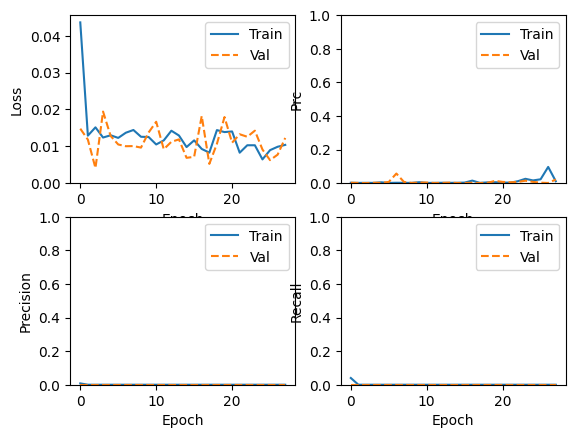

In [45]:
plot_metrics(baseline_history)

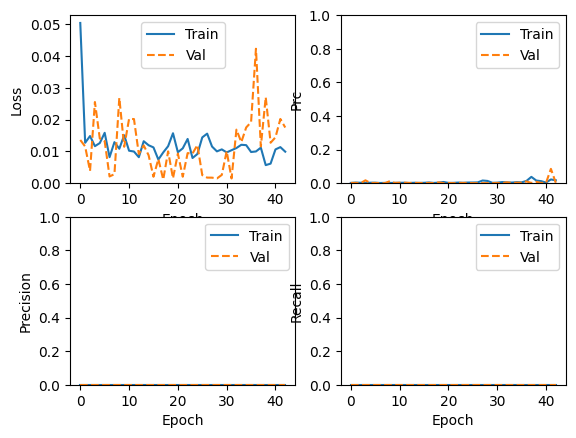

In [46]:
plot_metrics(baseline_history_ctx)

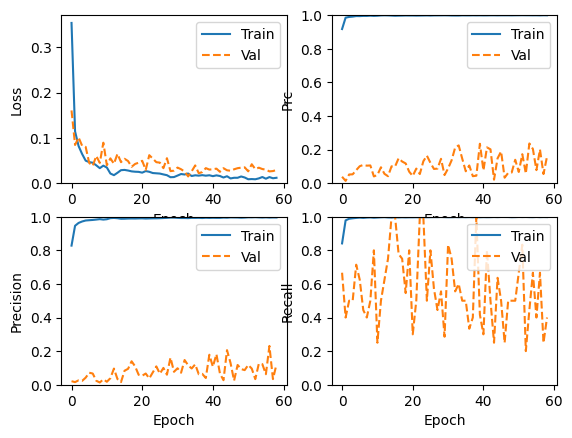

In [47]:
plot_metrics(baseline_history_resample)

Cosine Similarity classifier.

In [48]:
# Make a neural network which simply uses the cosine similarity between the question and the answer as the prediction
def cos_sim(x, y):
    return np.dot(x, y)/(np.linalg.norm(x)*np.linalg.norm(y))



In [62]:
from sklearn.metrics import auc, roc_curve
y_pred_keras = neural_net.predict(X_test).ravel()
y_pred_keras_ctx = neural_net_ctx.predict(X_test_ctx).ravel()
y_pred_keras_resample = neural_net_resample.predict(X_test).ravel()


fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
fpr_keras_ctx, tpr_keras_ctx, thresholds_keras_ctx = roc_curve(y_test_ctx, y_pred_keras_ctx)
fpr_keras_resample, tpr_keras_resample, thresholds_keras_resample = roc_curve(y_test, y_pred_keras_resample)


auc_keras = auc(fpr_keras, tpr_keras)
auc_keras_ctx = auc(fpr_keras_ctx, tpr_keras_ctx)
auc_keras_resample = auc(fpr_keras_resample, tpr_keras_resample)

14008/14008 [==============================] - 26s 2ms/step


In [63]:

y_pred_cos = np.asarray([cos_sim(x, y) for x, y in zip(X_test_q, X_test_c)])
# normalize the cosine similarity to be between 0 and 1
fpr_cos, tpr_cos, thresholds_cos = roc_curve(y_test, y_pred_cos)
auc_cos = auc(fpr_cos, tpr_cos)

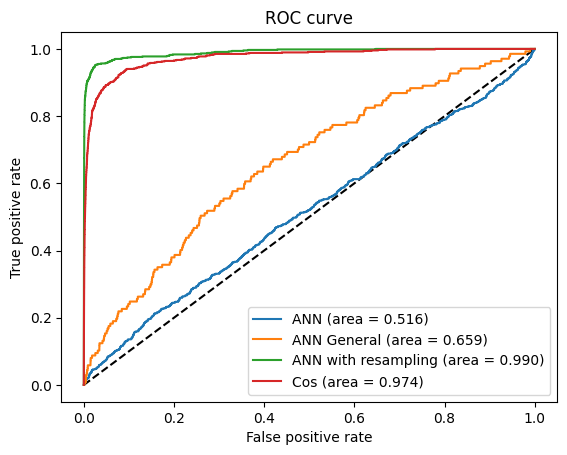

In [51]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ANN (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras_ctx, tpr_keras_ctx, label='ANN General (area = {:.3f})'.format(auc_keras_ctx))
plt.plot(fpr_keras_resample, tpr_keras_resample, label='ANN with resampling (area = {:.3f})'.format(auc_keras_resample))
plt.plot(fpr_cos, tpr_cos, label='Cos (area = {:.3f})'.format(auc_cos))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [52]:
batch_size = 128

In [53]:
import tensorflow as tf


class WeightedCosineSimilarity(tf.keras.layers.Layer):

    def __init__(self, units = batch_size, activation=None):
        '''Initializes the class and sets up the internal variables'''

        super(WeightedCosineSimilarity, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        '''Create the state of the layer (weights)'''
        # W should be half the size of the input and should be ones
        w_init = tf.ones_initializer()
        w_init_val = w_init(shape=(768), dtype='float32')
        self.w = tf.Variable(initial_value=w_init_val, trainable='true')



    def call(self, inputs):
        '''Defines the computation from inputs to outputs'''
        # Take the first half of the input which is U:
        U = inputs[:, :768]
        # Take the second half of the input which is V:
        V = inputs[:, 768:]

        # Compute the element wise product of U, V and W
        UW = tf.multiply(U, tf.exp(self.w))

        VW = tf.multiply(V, tf.exp(self.w))
        # Compute the multiplication of UW and VW
        UWVW = tf.multiply(UW, VW)
        # Sum the result over the second axis
        WUV = tf.reduce_sum(UWVW, axis=1)
        # Square U and V
        UW_squared = tf.square(UW)
        VW_squared = tf.square(VW)
        # Sum the result over the second axis
        UW_squared = tf.reduce_sum(UW_squared, axis=1)
        VW_squared = tf.reduce_sum(VW_squared, axis=1)
        # take the root of the sum of squares of WUV, WU_squared and WV_squared
        WU_squared_root = tf.sqrt(UW_squared)
        WV_squared_root = tf.sqrt(VW_squared)

        denominator = tf.multiply(WU_squared_root, WV_squared_root)

        # divide WUV by the denominator
        WUV_div_denominator = tf.divide(WUV, denominator)

        return self.activation(WUV_div_denominator)

gen = generator(chunk_dir_q='./Data_Generation/df_pickle/TEST_TRAIN_DATA/train_resample_q', chunk_dir_c='./Data_Generation/df_pickle/TEST_TRAIN_DATA/train_resample_c', chunk_dir_y='./Data_Generation/df_pickle/TEST_TRAIN_DATA/train_resample_y', batch_size=128)
X, y = next(gen)
model0 = WeightedCosineSimilarity()
model0.build(X.shape)
model0.call(X)


<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.5344779 ,  0.6159528 ,  0.09499104,  0.68535244,  0.65411603,
        0.03319827,  0.17919397,  0.6430854 ,  0.310313  ,  0.33628094,
        0.09614868, -0.00689103,  0.09250456,  0.61979324,  0.10909178,
        0.06117762,  0.06257958,  0.40421584,  0.23222539,  0.03253324,
        0.5811754 ,  0.64124185,  0.08126099,  0.57778424,  0.28974178,
        0.10480709, -0.06458025,  0.09071948,  0.70390254,  0.30551672,
       -0.00969312,  0.5290121 , -0.04915936,  0.41075894,  0.5356693 ,
        0.5979526 ,  0.06399971,  0.19739991,  0.50838834,  0.60236573,
        0.6047418 ,  0.15689713,  0.11526061,  0.65625256,  0.15119179,
        0.53871727, -0.04983621,  0.27548662,  0.40853262,  0.10429972,
        0.46217188,  0.6999202 ,  0.30815443,  0.5022164 ,  0.5641189 ,
        0.5961422 , -0.03039106,  0.55612606,  0.2655883 ,  0.3354416 ,
        0.01952813,  0.39405015,  0.5036428 ,  0.44583428,  0.17004691,
        0.676586

In [54]:
model_cos = tf.keras.models.Sequential([
    WeightedCosineSimilarity(batch_size)
])


In [55]:
model_cos.compile(loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'),
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR')])

In [56]:
baseline_history_cos = model_cos.fit(generator(chunk_dir_q='./Data_Generation/df_pickle/TEST_TRAIN_DATA/train_resample_q', chunk_dir_c='./Data_Generation/df_pickle/TEST_TRAIN_DATA/train_resample_c', chunk_dir_y= './Data_Generation/df_pickle/TEST_TRAIN_DATA/train_resample_y', batch_size=128),
                    steps_per_epoch=len(y_train_resample) // 12800, epochs=100,
                                  # validation data should also be a generator
                    validation_data=generator(chunk_dir_q='./Data_Generation/df_pickle/TEST_TRAIN_DATA/test_q', chunk_dir_c='./Data_Generation/df_pickle/TEST_TRAIN_DATA/test_c', chunk_dir_y= './Data_Generation/df_pickle/TEST_TRAIN_DATA/test_y', batch_size=128),
                    validation_steps=len(y_test) // 12800,
                                            verbose=1,
                                            callbacks=[early_stopping])

Epoch 1/100
280/280 [==============================] - 4s 10ms/step - loss: 0.4633 - tp: 8738.0000 - fp: 43.0000 - tn: 17879.0000 - fn: 9180.0000 - accuracy: 0.7427 - precision: 0.9951 - recall: 0.4877 - auc: 0.9743 - prc: 0.9765 - val_loss: 0.1260 - val_tp: 2.0000 - val_fp: 13.0000 - val_tn: 4460.0000 - val_fn: 5.0000 - val_accuracy: 0.9960 - val_precision: 0.1333 - val_recall: 0.2857 - val_auc: 0.9768 - val_prc: 0.2305
Epoch 2/100
280/280 [==============================] - 1s 3ms/step - loss: 0.4556 - tp: 9152.0000 - fp: 49.0000 - tn: 17852.0000 - fn: 8787.0000 - accuracy: 0.7535 - precision: 0.9947 - recall: 0.5102 - auc: 0.9735 - prc: 0.9753 - val_loss: 0.1404 - val_tp: 7.0000 - val_fp: 20.0000 - val_tn: 4448.0000 - val_fn: 5.0000 - val_accuracy: 0.9944 - val_precision: 0.2593 - val_recall: 0.5833 - val_auc: 0.9905 - val_prc: 0.2818
Epoch 3/100
280/280 [==============================] - 2s 6ms/step - loss: 0.4427 - tp: 9637.0000 - fp: 57.0000 - tn: 17932.0000 - fn: 8118.0000 - accu

In [57]:
y_pred_keras_cos_sim = model_cos.predict(X_test[0:len(y_test)- len(y_test) % 128], batch_size= batch_size).ravel()
fpr_cos_sim, tpr_cos_sim, thresholds_cos_sim = roc_curve(y_test[0:len(y_test)- len(y_test) % 128], y_pred_keras_cos_sim)
auc_cos_sim = auc(fpr_cos_sim, tpr_cos_sim)


3501/3501 [==============================] - 5s 2ms/step


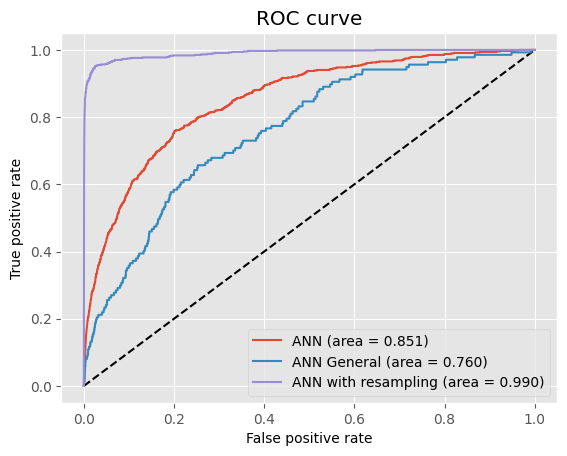

In [69]:
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
Line2D._us_dashSeq    = property(lambda self: self._dash_pattern[1])
Line2D._us_dashOffset = property(lambda self: self._dash_pattern[0])
Legend._ncol = property(lambda self: self._ncols)

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ANN (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras_ctx, tpr_keras_ctx, label='ANN General (area = {:.3f})'.format(auc_keras_ctx))
plt.plot(fpr_keras_resample, tpr_keras_resample, label='ANN with resampling (area = {:.3f})'.format(auc_keras_resample))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

# Transform to tikz code
tikzplotlib.clean_figure()
tikzplotlib.save("./Data_Generation/figures/roc_curve_ANN.tex")

import matplotlib as mpl
plt.show()
plt.close()
mpl.rcParams.update(mpl.rcParamsDefault)



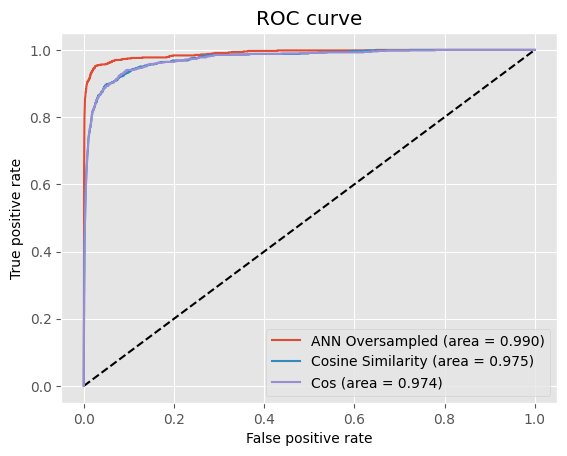

In [68]:

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_resample, tpr_keras_resample, label='ANN Oversampled (area = {:.3f})'.format(auc_keras_resample))
plt.plot(fpr_cos_sim, tpr_cos_sim, label='Cosine Similarity (area = {:.3f})'.format(auc_cos_sim))
plt.plot(fpr_cos, tpr_cos, label='Cos (area = {:.3f})'.format(auc_cos))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

# Transform to tikz code
tikzplotlib.clean_figure()
tikzplotlib.save("./Data_Generation/figures/roc_curve_final.tex")

import matplotlib as mpl
plt.show()
plt.close()
mpl.rcParams.update(mpl.rcParamsDefault)

In [72]:
#Save the weights
model_cos.save_weights('./ANN/model_cos.h5')
neural_net_resample.save_weights('./ANN/ANN_resamp.h5')